In [1]:
import argparse
import glob
from hydra import compose, initialize
import hydra
import numpy as np
import pandas as pd
import torch
import yaml
from omegaconf import DictConfig, OmegaConf
from dl4cv.utils.utils import set_seed
from dl4cv.lightning_classes.plmodel import LitODModel
from dl4cv.datasets import build_taco 
from dl4cv.datasets.taco_data import taco_val_test_collate_fn
from dl4cv.utils.object_detect_utils import get_iou, fix_orientation, mAP_calc, calc_total_mAP
from tqdm import tqdm
import os


In [2]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(config_path="./configs")
inference_cfg = compose(config_name="config_taco_training")
inference_cfg["inference"]["run_name"] = 'Resnet50_Whale_bs1_return128'
inference_cfg["inference"]["device"] = 'cuda:1'
path = f"outputs/{inference_cfg.inference.run_name}/.hydra/config.yaml"
with open(path) as cfg:
    cfg_yaml = yaml.safe_load(cfg)
cfg_yaml["inference"] = inference_cfg["inference"]
cfg_yaml["datamodule"]["test"]["params"]["num_to_return"] = 100
cfg = OmegaConf.create(cfg_yaml)


In [3]:
def main(cfg: DictConfig) -> None:
    """
    Run pytorch-lightning model inference
    Args:
        cfg: hydra config
    Returns:
        None
    """
    set_seed(cfg.training.seed)

    device = torch.device(cfg.inference.device)

    model_names = glob.glob(f"outputs/{cfg.inference.run_name}/saved_models/*.ckpt")
    _, _, test_set, inference_set = build_taco(cfg)
    inference_set.num_to_return = 1024
    loader = torch.utils.data.DataLoader(
        inference_set,
        collate_fn=taco_val_test_collate_fn,
        batch_size=1,
        num_workers=1,
        shuffle=False,
    )
    lit_model = LitODModel.load_from_checkpoint(checkpoint_path=model_names[0], cfg=cfg)
    lit_model.to(device)
    predictions = []
    for batch in tqdm(loader):
        # move batch elements to device
        batch = tuple(b.to(device) for b in batch)
        predictions.append(
            lit_model.nms_on_image(
                batch,
            )
        )

    return predictions, inference_set




In [4]:
predictions, inference_set = main(cfg)

 24%|████████████████████████████████████▎                                                                                                                     | 59/250 [02:47<08:44,  2.75s/it]

Len region keys: 995
Oversampling!!!


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 185/250 [08:46<03:04,  2.83s/it]

Len region keys: 817
Oversampling!!!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [11:49<00:00,  2.84s/it]


In [5]:
# find an index in predictions where the kept_preds are not empty
# valids = []
# for i in range(len(predictions)):
#     if len(predictions[i]['kept_preds']) > 0:
#         valids.append(i)

In [6]:
#predictions[4]

In [7]:
pred = []
truth = []

for i in range(len(predictions)):
    if len(predictions[i]['kept_preds']) > 0:
        pred.append(predictions[i]['kept_preds'])
        _gt_boxes = predictions[i]['gt_regions']
        _gt_classes = predictions[i]['gt_labels']
        _truth = []
        for j in range(len(_gt_boxes)):
            _box = {'x1':_gt_boxes[j][0].item(), 'x2':_gt_boxes[j][1].item(), 'y1':_gt_boxes[j][2].item(), 'y2':_gt_boxes[j][3].item()}
            _class = _gt_classes[j].item()
            _truth.append({'bbox':_box, 'pred_class':_class})
        truth.append(_truth)

In [8]:
print(f'mAP calculated wrongly: {calc_total_mAP(pred,truth)} and correctly {mAP_calc(pred,truth)}')



Image mAPs: {0: {12: 0}, 1: {0: 0, 25: 0, 2: 0}, 2: {17: 0, 27: 0, 4: 0}, 3: {24: 0, 9: 1, 20: 1, 4: 0}, 4: {0: 0, 2: 1}, 5: {8: 1, 9: 1}, 6: {9: 1, 19: 1}, 7: {8: 0, 4: 0}, 8: {21: 1}, 9: {8: 0, 4: 0}, 10: {17: 1, 27: 0}, 11: {2: 0}, 12: {9: 0, 11: 1}, 13: {17: 0, 26: 0}, 14: {2: 0}, 15: {8: 0, 26: 0, 20: 0}, 16: {8: 0, 4: 1}, 17: {26: 0}, 18: {9: 1, 26: 0, 2: 0}, 19: {0: 0, 1: 0, 2: 0, 4: 0, 9: 0, 17: 0}, 20: {0: 0, 9: 0, 11: 1}, 21: {8: 1}, 22: {0: 0, 9: 0, 12: 0, 21: 1}, 23: {2: 0}, 24: {8: 0, 9: 0.5, 4: 1, 17: 0}, 25: {4: 0}, 26: {8: 0, 4: 1, 20: 1}, 27: {2: 0, 12: 0}, 28: {2: 1}, 29: {20: 1}, 30: {9: 0, 23: 0}, 31: {2: 0}, 32: {9: 0}, 33: {0: 0, 8: 0}, 34: {2: 1}, 35: {0: 0, 23: 0}, 36: {0: 0, 2: 0, 9: 0, 20: 0, 27: 0}, 37: {0: 0, 4: 1}, 38: {2: 1}, 39: {2: 0, 6: 0, 9: 0, 23: 1, 27: 0}, 40: {8: 0, 17: 0, 20: 0, 21: 0, 23: 0, 27: 0}, 41: {21: 0}, 42: {0: 0, 2: 0, 4: 0, 20: 0, 24: 0}, 43: {9: 0, 2: 0, 23: 0}, 44: {18: 0, 21: 0}, 45: {12: 1}, 46: {8: 0.5, 4: 0}, 47: {8: 1, 24: 0, 4:

In [24]:
pred[3]

[{'bbox': {'x1': 595, 'y1': 315, 'x2': 761, 'y2': 379},
  'conf': 0.8869669437408447,
  'pred_class': 9,
  'true_class': 28,
  'image_id': 816},
 {'bbox': {'x1': 594, 'y1': 283, 'x2': 804, 'y2': 393},
  'conf': 0.7752134203910828,
  'pred_class': 9,
  'true_class': 9,
  'image_id': 816},
 {'bbox': {'x1': 599, 'y1': 349, 'x2': 664, 'y2': 370},
  'conf': 0.6732715368270874,
  'pred_class': 27,
  'true_class': 28,
  'image_id': 816},
 {'bbox': {'x1': 420, 'y1': 335, 'x2': 436, 'y2': 348},
  'conf': 0.45864030718803406,
  'pred_class': 20,
  'true_class': 20,
  'image_id': 816},
 {'bbox': {'x1': 566, 'y1': 317, 'x2': 611, 'y2': 358},
  'conf': 0.4141601324081421,
  'pred_class': 27,
  'true_class': 28,
  'image_id': 816},
 {'bbox': {'x1': 313, 'y1': 272, 'x2': 427, 'y2': 328},
  'conf': 0.4014344811439514,
  'pred_class': 8,
  'true_class': 28,
  'image_id': 816},
 {'bbox': {'x1': 613, 'y1': 356, 'x2': 701, 'y2': 383},
  'conf': 0.38349249958992004,
  'pred_class': 9,
  'true_class': 28,
 

In [10]:
pred[3]

img = inference_set._get_image(inference_set.regions[3])
Item = inference_set.__getitem__(3)

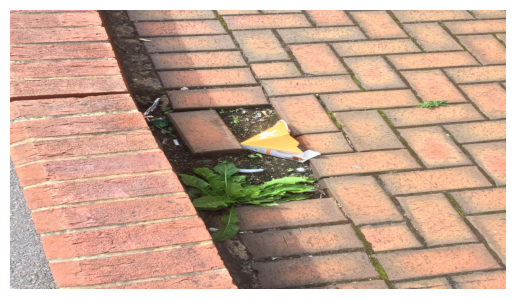

In [11]:
from PIL import Image
PIL_image = Image.fromarray(np.uint8(img)).convert('RGB')

import matplotlib.pyplot as plt
fig,ax = plt.subplots(1)
plt.axis('off')
plt.imshow(PIL_image)

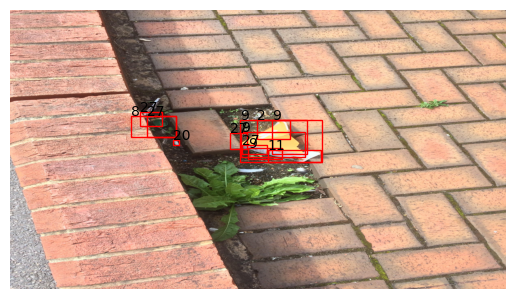

In [12]:
# plot the bounding boxes with class label as text
import matplotlib.patches as patches
import numpy as np
import matplotlib.pyplot as plt

# Create figure and axes
fig,ax = plt.subplots(1)
plt.axis('off')

# Display the image
ax.imshow(PIL_image)

# Create a Rectangle patch
for i in range(len(pred[3])):
    _box = pred[3][i]['bbox']
    _class = pred[3][i]['pred_class']
    rect = patches.Rectangle((_box['x1'],_box['y1']),_box['x2']-_box['x1'],_box['y2']-_box['y1'],linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    ax.text(_box['x1'],_box['y1'],str(_class))

plt.show()


In [22]:
# read json
import json
with open('/dtu/blackhole/0f/160495/s210527/taco_again/cat2supercat_encoded.json') as f:
    cat2supercat = json.load(f)

with open('/dtu/blackhole/0f/160495/s210527/taco_again/supercat2id.json') as f:
    supercat2id = json.load(f)


In [21]:
cat2supercat

{'0': 24,
 '1': 13,
 '2': 25,
 '3': 25,
 '4': 8,
 '5': 8,
 '6': 8,
 '7': 4,
 '8': 4,
 '9': 1,
 '10': 21,
 '11': 21,
 '12': 21,
 '13': 9,
 '14': 9,
 '15': 9,
 '16': 9,
 '17': 9,
 '18': 9,
 '19': 9,
 '20': 27,
 '21': 27,
 '22': 27,
 '23': 27,
 '24': 27,
 '25': 14,
 '26': 22,
 '27': 17,
 '28': 17,
 '29': 12,
 '30': 11,
 '31': 11,
 '32': 11,
 '33': 11,
 '34': 5,
 '35': 5,
 '36': 2,
 '37': 2,
 '38': 2,
 '39': 2,
 '40': 2,
 '41': 2,
 '42': 2,
 '43': 26,
 '44': 26,
 '45': 26,
 '46': 26,
 '47': 26,
 '48': 10,
 '49': 6,
 '50': 18,
 '51': 16,
 '52': 7,
 '53': 3,
 '54': 15,
 '55': 23,
 '56': 23,
 '57': 19,
 '58': 0,
 '59': 20}

In [23]:
supercat2id

{'Unlabeled litter': 0,
 'Broken glass': 1,
 'Plastic bag & wrapper': 2,
 'Shoe': 3,
 'Bottle cap': 4,
 'Paper bag': 5,
 'Plastic utensils': 6,
 'Scrap metal': 7,
 'Bottle': 8,
 'Carton': 9,
 'Plastic glooves': 10,
 'Paper': 11,
 'Other plastic': 12,
 'Battery': 13,
 'Food waste': 14,
 'Squeezable tube': 15,
 'Rope & strings': 16,
 'Lid': 17,
 'Pop tab': 18,
 'Styrofoam piece': 19,
 'Cigarette': 20,
 'Can': 21,
 'Glass jar': 22,
 'Straw': 23,
 'Aluminium foil': 24,
 'Blister pack': 25,
 'Plastic container': 26,
 'Cup': 27}

In [ ]:
# Create figure and axes
fig,ax = plt.subplots(1)
plt.axis('off')

# Display the image
ax.imshow(PIL_image)

# Create a Rectangle patch
for i in range(len(pred[3])):
    _box = truth[3][i]['bbox']
    _class = pred[3][i]['pred_class']
    rect = patches.Rectangle((_box['x1'],_box['y1']),_box['x2']-_box['x1'],_box['y2']-_box['y1'],linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    ax.text(_box['x1'],_box['y1'],str(_class))

plt.show()
